In [3]:

import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

!pip install xgboost
!pip install imbalanced-learn


In [4]:

file_path = os.path.expanduser("~/Desktop/EEG/EEG.csv")
df = pd.read_csv(file_path)

waves = ["delta", "theta", "alpha", "beta", "gamma"]
prefixes = ["AB", "COH"]
new_cols = {}

for prefix in prefixes:
    for wave in waves:
        cols = [col for col in df.columns
                if col.startswith(prefix) and re.search(rf'\b{wave}\b', col)]
        
        if cols:
            new_col_name = f"{prefix}_{wave}"
            new_cols[new_col_name] = df[cols].mean(axis=1)
        else:
            print(f"Uyarı: '{prefix}_{wave}' için sütun bulunamadı.")

before = df.iloc[:, :8] 
after = df.iloc[:, 8:]   

inserted = pd.DataFrame(new_cols)
df = pd.concat([before, inserted, after], axis=1)
output_path = os.path.expanduser("~/Desktop/EEG/EEG_dalgalar.csv")
df.to_csv(output_path, index=False)

print("Tamamlandı ✅ Yeni dosya:", output_path)


Tamamlandı ✅ Yeni dosya: /Users/beydabucak/Desktop/EEG/EEG_dalgalar.csv


In [5]:
if "is_healthy" in df.columns:
    df = df.drop(columns=["is_healthy"])

df.insert(4, "is_healthy", df["main.disorder"].apply(
    lambda x: 1 if str(x).strip().lower() == "Healthy control" else 0
))


In [6]:
# 1. Korunacak sütunlar

file_path = os.path.expanduser("~/Desktop/EEG/EEG_dalgalarr.csv")
df = pd.read_csv(file_path)


keep_cols = [
    "AB_delta", "AB_theta", "AB_alpha", "AB_beta", "AB_gamma",
    "COH_delta", "COH_theta", "COH_alpha", "COH_beta", "COH_gamma", "main.disorder", "specific.disorder", "IQ", 
    "education", "is_healthy", "age"
]

df = df[keep_cols].copy()
output_path = os.path.expanduser("~/Desktop/EEG/EEG_dalgalar.csv")
df.to_csv(output_path, index=False)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AB_delta           930 non-null    float64
 1   AB_theta           930 non-null    float64
 2   AB_alpha           930 non-null    float64
 3   AB_beta            930 non-null    float64
 4   AB_gamma           930 non-null    float64
 5   COH_delta          930 non-null    float64
 6   COH_theta          930 non-null    float64
 7   COH_alpha          930 non-null    float64
 8   COH_beta           930 non-null    float64
 9   COH_gamma          930 non-null    float64
 10  main.disorder      930 non-null    object 
 11  specific.disorder  930 non-null    object 
 12  IQ                 930 non-null    float64
 13  education          930 non-null    float64
 14  is_healthy         930 non-null    int64  
 15  age                930 non-null    int64  
dtypes: float64(12), int64(2), 


 Logistic Regression Accuracy: 0.6618
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        91
    Disorder       0.66      0.99      0.80       181

    accuracy                           0.66       272
   macro avg       0.33      0.50      0.40       272
weighted avg       0.44      0.66      0.53       272


 SVM Accuracy: 0.7096
              precision    recall  f1-score   support

     Healthy       0.68      0.25      0.37        91
    Disorder       0.71      0.94      0.81       181

    accuracy                           0.71       272
   macro avg       0.70      0.60      0.59       272
weighted avg       0.70      0.71      0.66       272


 KNN Accuracy: 0.9228
              precision    recall  f1-score   support

     Healthy       0.81      1.00      0.90        91
    Disorder       1.00      0.88      0.94       181

    accuracy                           0.92       272
   macro avg       0.91      0.94      0.92

/var/folders/6g/vrjgsm_n7tn7rg9yhk0tgwj00000gn/T/ipykernel_14436/259590477.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=model_names, palette='mako')


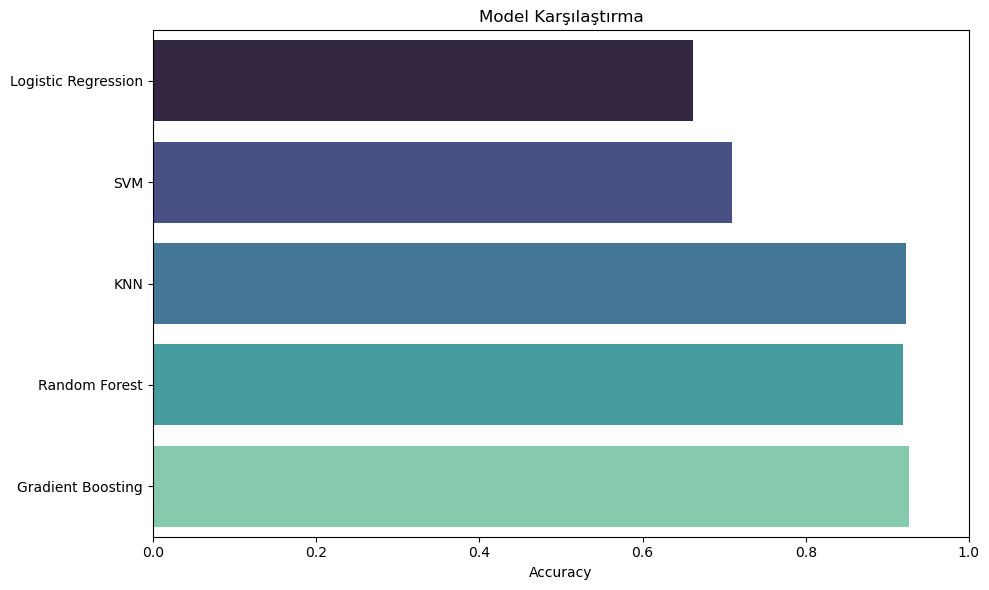

In [8]:


df = pd.read_csv("~/Desktop/EEG/EEG_dalgalarr.csv")
df["sex"] = df["sex"].map({"M": 1, "F": 0})
features = ['AB_theta', 'AB_delta']
target = 'is_healthy'
df = df[features + [target]].dropna()

healthy = df[df['is_healthy'] == 1]
disorder = df[df['is_healthy'] == 2]
n_disorder = len(disorder)
healthy_augmented = healthy.copy()
for col in features:
    noise = np.random.normal(0, 0.03 * healthy[col].std(), size=len(healthy))
    healthy_augmented[col] += noise
healthy_upsampled = pd.concat([healthy, healthy_augmented]).sample(n=int(n_disorder * 0.5), replace=True, random_state=42)
df_balanced = pd.concat([healthy_upsampled, disorder]).sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced[features]
y = df_balanced[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=10, min_samples_leaf=5, 
                                            class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results.append((name, acc))
    print(f"\n {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Healthy", "Disorder"]))

best_model = max(results, key=lambda x: x[1])
print(f"\n En iyi model: {best_model[0]} ({best_model[1]:.4f} doğruluk)")

model_names, scores = zip(*results)
plt.figure(figsize=(10,6))
sns.barplot(x=scores, y=model_names, palette='mako')
plt.xlabel("Accuracy")
plt.title("Model Karşılaştırma")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


 Accuracy: 0.9485
              precision    recall  f1-score   support

     Healthy       0.96      0.88      0.92        91
    Disorder       0.94      0.98      0.96       181

    accuracy                           0.95       272
   macro avg       0.95      0.93      0.94       272
weighted avg       0.95      0.95      0.95       272



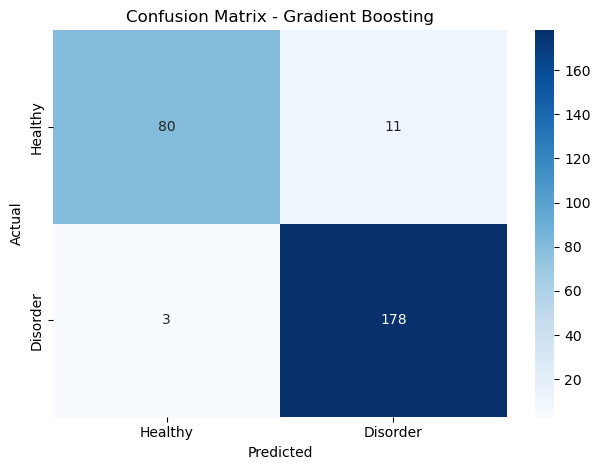

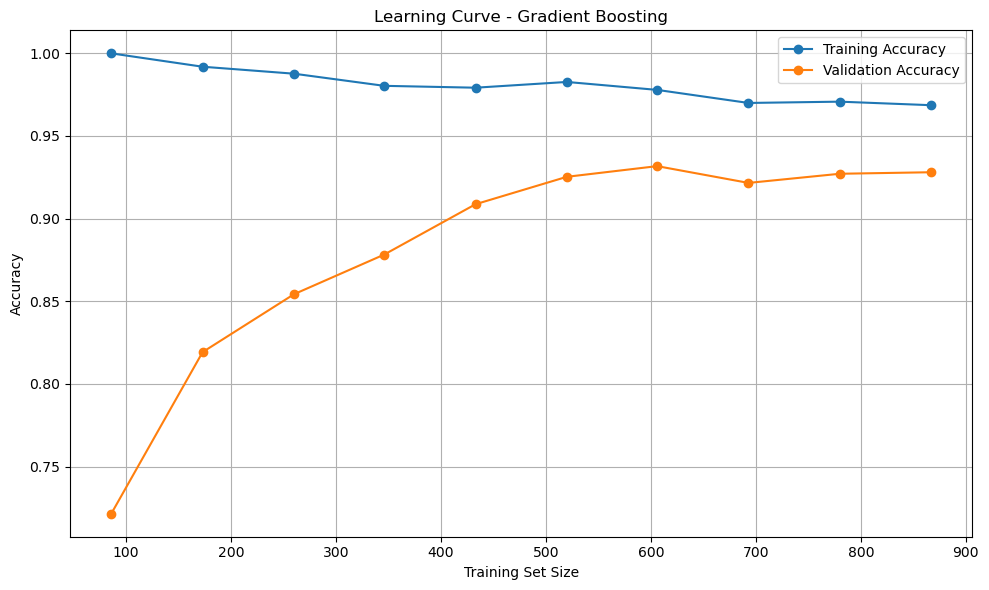

In [9]:

df = pd.read_csv("~/Desktop/EEG/EEG_dalgalarr.csv")
df["sex"] = df["sex"].map({"M": 1, "F": 0})
features = ['AB_theta', 'AB_delta']
target = 'is_healthy'
df = df[features + [target]].dropna()

healthy = df[df['is_healthy'] == 1]
disorder = df[df['is_healthy'] == 2]
n_disorder = len(disorder)
healthy_augmented = healthy.copy()
for col in features:
    noise = np.random.normal(0, 0.03 * healthy[col].std(), size=len(healthy))
    healthy_augmented[col] += noise
healthy_upsampled = pd.concat([healthy, healthy_augmented]).sample(n=int(n_disorder * 0.5), replace=True, random_state=42)
df_balanced = pd.concat([healthy_upsampled, disorder]).sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced[features]
y = df_balanced[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f" Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Disorder"]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Disorder"], yticklabels=["Healthy", "Disorder"])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation Accuracy')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Gradient Boosting")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


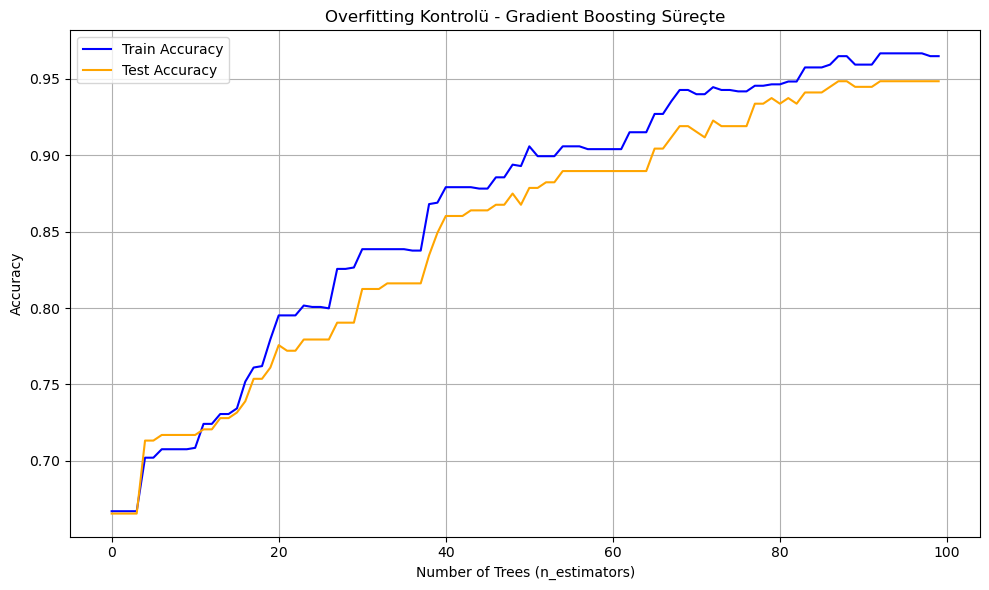

In [10]:
train_acc_list = []
test_acc_list = []

for y_train_pred in model.staged_predict(X_train_scaled):
    train_acc_list.append(accuracy_score(y_train, y_train_pred))

for y_test_pred in model.staged_predict(X_test_scaled):
    test_acc_list.append(accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(10, 6))
plt.plot(train_acc_list, label='Train Accuracy', color='blue')
plt.plot(test_acc_list, label='Test Accuracy', color='orange')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Overfitting Kontrolü - Gradient Boosting Süreçte")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


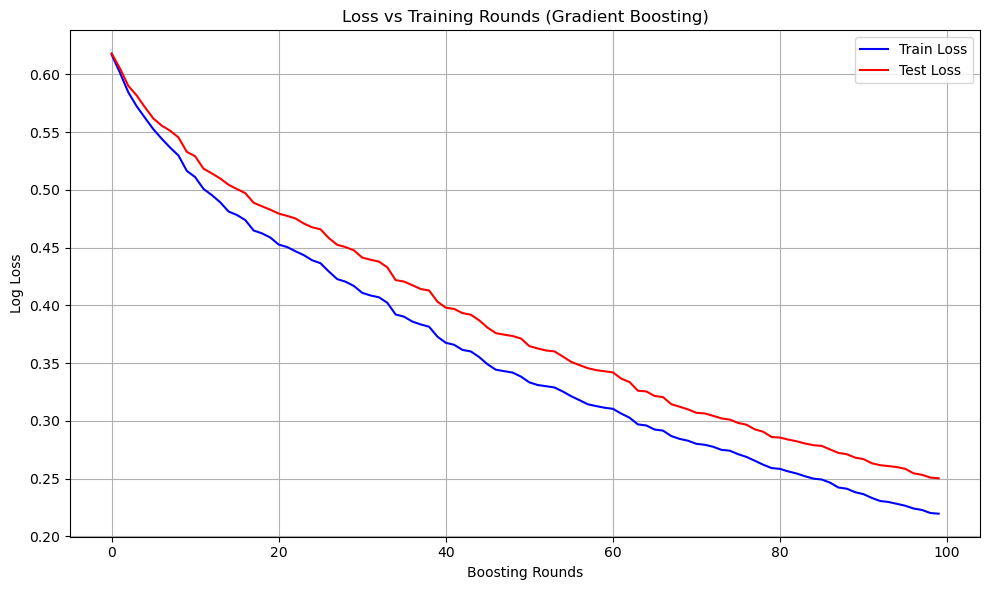

In [11]:


gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train)

train_loss = []
test_loss = []

for y_train_pred_proba, y_test_pred_proba in zip(gb_model.staged_predict_proba(X_train_scaled),
                                                  gb_model.staged_predict_proba(X_test_scaled)):
    train_loss.append(log_loss(y_train, y_train_pred_proba))
    test_loss.append(log_loss(y_test, y_test_pred_proba))

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss", color='blue')
plt.plot(test_loss, label="Test Loss", color='red')
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Loss vs Training Rounds (Gradient Boosting)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/6g/vrjgsm_n7tn7rg9yhk0tgwj00000gn/T/ipykernel_14436/194098896.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


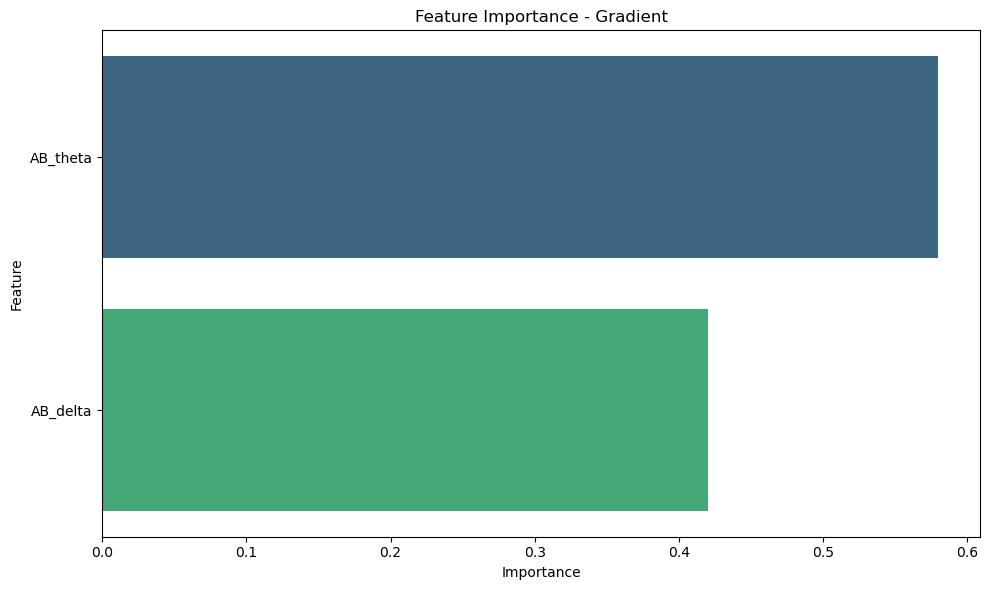

In [12]:
importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importance - Gradient")
plt.tight_layout()
plt.show()



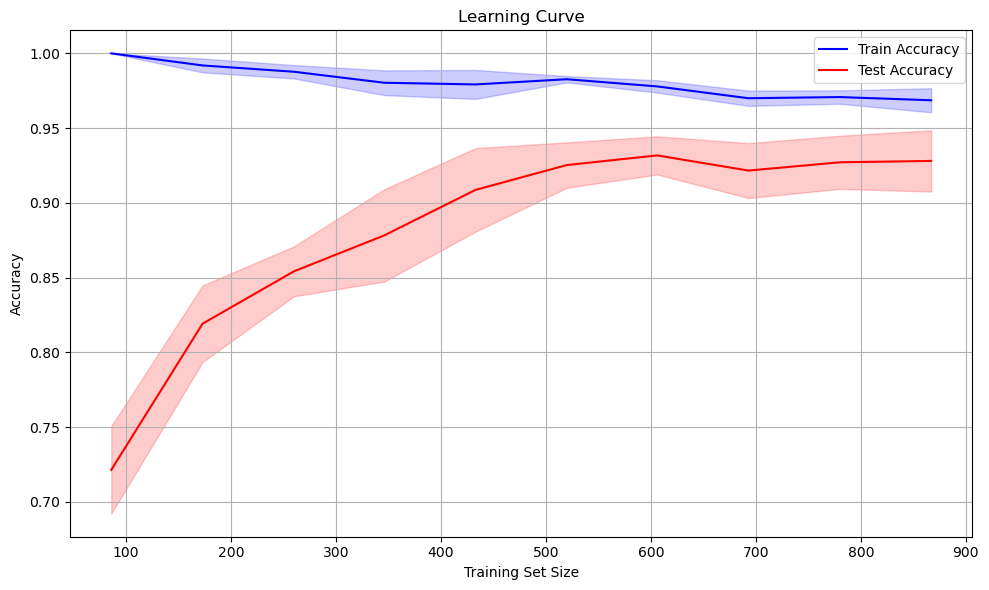

In [13]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy', n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Train Accuracy", color='blue')
plt.plot(train_sizes, test_mean, label="Test Accuracy", color='red')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='red', alpha=0.2)

plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
print(df_balanced['is_healthy'].value_counts())


is_healthy
2    904
1    452
Name: count, dtype: int64


In [16]:
results = pd.DataFrame([{
    'AB_theta': 8,
    'AB_delta': 10
}])
results_scaled = scaler.transform(results)

prob = model.predict_proba(results_scaled)[0]
healthy_prob = prob[model.classes_ == 1][0] * 100
disorder_prob = prob[model.classes_ == 2][0] * 100

if disorder_prob >= 53:
    print(f"%{disorder_prob:.1f} oranında EEG verilerine göre bir rahatsızlık gözlemlenme olasılığı var.")
    print("Bu bir teşhis değildir, ancak bir uzmana danışmanız önerilir.")
else:
    print(f"%{healthy_prob:.1f} oranında EEG verilerine göre sağlıklı görünüyorsunuz.")
    print("EEG sonuçları açısından belirgin bir bozukluk gözlemlenmedi.")


%57.2 oranında EEG verilerine göre sağlıklı görünüyorsunuz.
EEG sonuçları açısından belirgin bir bozukluk gözlemlenmedi.


In [18]:
import joblib

joblib.dump(model, "eeg_model.pkl")
joblib.dump(scaler, "eeg_scaler.pkl")

print("Model ve scaler başarıyla kaydedildi.")


Model ve scaler başarıyla kaydedildi.
